In [12]:
import pandas as pd
import sqlite3

In [13]:
connect_db = sqlite3.connect('../data/checking-logs.sqlite.sqlite')
query = 'PRAGMA table_info(checker);'
pd.io.sql.read_sql(query, connect_db)

,cid,name,type,notnull,dflt_value,pk
0,0,index,INTEGER,0,None,0
1,1,status,TEXT,0,None,0
2,2,success,INTEGER,0,None,0
3,3,timestamp,TIMESTAMP,0,None,0
4,4,numTrials,INTEGER,0,None,0
5,5,labname,TEXT,0,None,0
6,6,uid,TEXT,0,None,0


In [14]:
query = '''
        select uid, timestamp from checker where uid like 'user_%'
        '''
df = pd.io.sql.read_sql(query, connect_db, parse_dates=['timestamp'])
df.head()

,uid,timestamp
0,user_4,2020-04-17 05:19:02.744528
1,user_4,2020-04-17 05:22:35.249331
2,user_4,2020-04-17 05:22:45.549397
3,user_4,2020-04-17 05:34:14.691200
4,user_4,2020-04-17 05:34:24.422370


In [15]:
df['day'] = df.timestamp.dt.day
df['weekday'] = df.timestamp.dt.dayofweek
df['hour'] = df.timestamp.dt.hour
df.drop('timestamp', axis=1, inplace=True)
df

,uid,day,weekday,hour
0,user_4,17,4,5
1,user_4,17,4,5
2,user_4,17,4,5
3,user_4,17,4,5
4,user_4,17,4,5
...,...,...,...,...
3202,user_1,21,3,20
3203,user_1,21,3,20
3204,user_1,21,3,20
3205,user_1,21,3,20


In [16]:
ds = df

ds.loc[df['weekday'] < 5, 'weekday'] = 'working_day'
ds.loc[df['weekday'] != 'working_day', 'weekday'] = 'weekend'

In [17]:
group_by = ds.groupby(['weekday', 'day', 'hour']).count()
group_by_new = group_by.groupby(['weekday','hour']).mean()['uid'].reset_index()
group_by_new

,weekday,hour,uid
0,weekend,0,2.000000
1,weekend,1,6.000000
2,weekend,3,1.000000
3,weekend,5,2.000000
4,weekend,7,4.000000
5,weekend,8,7.000000
6,weekend,9,3.666667
7,weekend,10,7.000000
8,weekend,11,23.600000
9,weekend,12,9.500000


In [18]:
pivot_table = pd.pivot(group_by_new, values='uid',index='hour', columns='weekday')
hour = pd.DataFrame([i for i in range(0, 24)], columns=['hour'])
pivot_table = hour.merge(pivot_table, how='left', on='hour').set_index('hour')
pivot_table

,weekend,working_day
hour,,
0,2.000000,3.000000
1,6.000000,NaN
2,NaN,NaN
3,1.000000,2.000000
4,NaN,NaN
5,2.000000,7.500000
6,NaN,1.500000
7,4.000000,5.166667
8,7.000000,3.700000


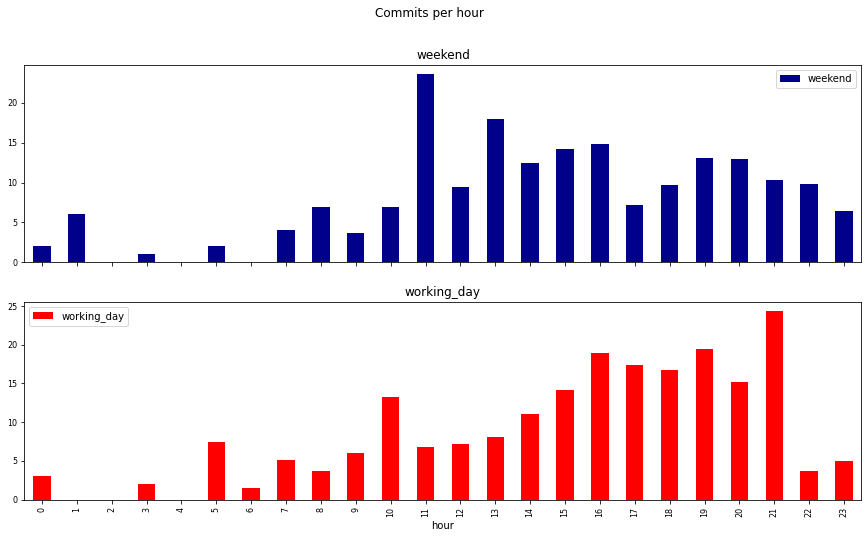

In [19]:
plot = pivot_table.plot(kind='bar', figsize= (15,8), title = 'Commits per hour', fontsize=8, xlabel = 'hour', rot = 90, color = ['#00008B', 'red'], sharex=True, subplots=True)

Is the dynamic different on working days and weekends?

In [20]:
pivot_table[pivot_table.working_day == pivot_table.working_day.max()]

,weekend,working_day
hour,,
21,10.285714,24.333333



evening and afternoon


Which day has the most number of commits and at the same time the number of commits in the evening is higher than in the afternoon?

In [21]:
pivot_table[pivot_table.weekend == pivot_table.weekend.max()]

,weekend,working_day
hour,,
11,23.6,6.769231



working_day  = 21 , weekday = 11

In [22]:
connect_db.close()